In [ ]:
pip install diffusers transformers accelerate scipy safetensors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 856.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

### inpainting 초기 시도
공식 문서 확인 이전

In [ ]:
# 필수 라이브러리 설치
!pip install diffusers==0.27.2 accelerate==0.27.2 transformers==4.40.0 torch torchvision

import os
import random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from tqdm import tqdm
from diffusers import UNet2DConditionModel, StableDiffusionInpaintPipeline, DDPMScheduler
from transformers import CLIPTokenizer, CLIPTextModel
import matplotlib.pyplot as plt

class LaneInpaintingDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.filenames = [
            f for f in os.listdir(img_dir) if f.endswith('.jpg')
        ]
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        mask_name = img_name.replace('.jpg', '_mask.png')
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(img_path).convert("RGB")    # RGBA 방지
        mask = Image.open(mask_path).convert("L")      # Binary mask

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        else:
            image = np.array(image).transpose(2, 0, 1) / 255.0
            mask = np.array(mask)[None, ...] / 255.0   # (1, H, W)
        return {
            "image": torch.FloatTensor(image),
            "mask": torch.FloatTensor(mask),
        }

damaged_folder = "/content/drive/MyDrive/masked_images"
mask_folder = "/content/drive/MyDrive/mask_all"

dataset = LaneInpaintingDataset(damaged_folder, mask_folder)
total_size = len(dataset)
train_size = int(0.6 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False)
test_loader = DataLoader(test_set, batch_size=4, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"

# 텍스트 인코더 및 토크나이저
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to(device)

# UNet (inpainting)
unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet").to(device)

# Noise scheduler
scheduler = DDPMScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")

optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-5)

EPOCHS = 50
output_folder = "/content/drive/MyDrive/ControlNet_outputs"
checkpoint_folder = "/content/checkpoints"
os.makedirs(output_folder, exist_ok=True)
os.makedirs(checkpoint_folder, exist_ok=True)

prompt = "restore lane markings on damaged road"
input_ids = tokenizer([prompt], return_tensors="pt").input_ids.to(device)
early_stop_patience = 7
best_val_loss = np.inf
patience = 0

train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    unet.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        images = batch["image"].to(device)
        masks = batch["mask"].to(device)
        # 텍스트 인코딩
        encoder_hidden_states = text_encoder(input_ids).last_hidden_state
        # noise 추가
        noise = torch.randn_like(images)
        timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (images.size(0),), device=device).long()
        noisy_images = scheduler.add_noise(images, noise, timesteps)
        # forward
        model_pred = unet(noisy_images, timesteps, encoder_hidden_states, return_dict=True).sample
        loss = torch.nn.functional.mse_loss(model_pred, noise)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # validation
    unet.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"].to(device)
            masks = batch["mask"].to(device)
            encoder_hidden_states = text_encoder(input_ids).last_hidden_state
            noise = torch.randn_like(images)
            timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (images.size(0),), device=device).long()
            noisy_images = scheduler.add_noise(images, noise, timesteps)
            model_pred = unet(noisy_images, timesteps, encoder_hidden_states, return_dict=True).sample
            loss = torch.nn.functional.mse_loss(model_pred, noise)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # 체크포인트 저장
    if (epoch + 1) % 5 == 0:
        torch.save(unet.state_dict(), os.path.join(checkpoint_folder, f"unet_epoch{epoch+1}.pth"))
        # 시각화 예시
        test_batch = next(iter(val_loader))
        with torch.no_grad():
            images = test_batch["image"].to(device)
            encoder_hidden_states = text_encoder(input_ids).last_hidden_state
            timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (images.size(0),), device=device).long()
            noise = torch.randn_like(images)
            noisy_images = scheduler.add_noise(images, noise, timesteps)
            model_pred = unet(noisy_images, timesteps, encoder_hidden_states, return_dict=True).sample
            # 결과 저장
            for i in range(min(2, images.size(0))):
                out_img = (noisy_images[i].cpu().numpy().transpose(1,2,0) * 255).astype(np.uint8)
                plt.imsave(os.path.join(output_folder, f"epoch{epoch+1}_sample{i+1}.png"), out_img)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience = 0
        torch.save(unet.state_dict(), os.path.join(output_folder, "fine_tuned_controlnet_final.pth"))
    else:
        patience += 1
        if patience > early_stop_patience:
            print("Early stopping!")
            break

# loss 그래프 저장
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend(); plt.savefig(os.path.join(output_folder, "loss_curve.png"))


## inpainting

### 기본 inpainting 마스크를 이용한 손상 이미지 복원

In [11]:
import os
from tqdm import tqdm
from PIL import Image, ImageOps
import torch
from diffusers import StableDiffusionInpaintPipeline

mask_folder     = "/content/drive/MyDrive/viz_inpainting_mask"     # 기본 inpainting mask
#mask_folder     = "/content/drive/MyDrive/viz_prediction"     # changed 마스크
damaged_folder  = "/content/drive/MyDrive/viz_origin_masked"     # 손상된(원본+마스크) 이미지
output_folder   = "/content/inpainting_output_0609_1620"
os.makedirs(output_folder, exist_ok=True)

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)
pipe.to("cuda")

prompt = "a road with clear, straight white lane markings"
steps  = 50

for mask_fn in tqdm(sorted(os.listdir(mask_folder)), desc="Final-mask Inpainting"):
    # 1) PNG 파일만 처리
    if not mask_fn.lower().endswith(".png"):
        continue

    # 2) "_final_mask.png" 접미사 제거 → basename 생성
    basename = mask_fn.replace("_origin_mask.png", "")

    # 3) 경로 설정
    mask_path    = os.path.join(mask_folder, mask_fn)
    damaged_path = os.path.join(damaged_folder, f"{basename}_origin.png")
    output_path  = os.path.join(output_folder, f"{basename}_inpainted.png")

    # 4) 스킵 로직
    if not os.path.exists(damaged_path):
        print(f"[SKIP] 손상 이미지 없음: {damaged_path}")
        continue
    if os.path.exists(output_path):
        print(f"[SKIP] 이미 처리됨: {output_path}")
        continue

    TARGET = (512, 512)
    init_image = Image.open(damaged_path).convert("RGB").resize(TARGET)
    mask_image = Image.open(mask_path).convert("L").resize(TARGET)
    # 5) 이미지 & 마스크 로드 + 스케일
    #scale_ratio = 1.0
    #init_image = ImageOps.scale(Image.open(damaged_path).convert("RGB"), scale_ratio)
    #mask_image = ImageOps.scale(Image.open(mask_path).convert("L"), scale_ratio)

    # 6) Inpainting
    with torch.autocast("cuda"):
        result = pipe(
            prompt=prompt,
            image=init_image,
            mask_image=mask_image,
            num_inference_steps=steps
        ).images[0]

    # 7) 저장
    result.save(output_path)
    print(f"[SAVE] {output_path}")

print("✅ Final-mask 기반 Inpainting 완료:", output_folder)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Final-mask Inpainting:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:   3%|▎         | 1/30 [00:07<03:36,  7.46s/it]

[SAVE] /content/inpainting_output_0609_1620/13905755_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:   7%|▋         | 2/30 [00:14<03:28,  7.44s/it]

[SAVE] /content/inpainting_output_0609_1620/13926745_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  10%|█         | 3/30 [00:22<03:21,  7.45s/it]

[SAVE] /content/inpainting_output_0609_1620/13956944_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  13%|█▎        | 4/30 [00:29<03:15,  7.50s/it]

[SAVE] /content/inpainting_output_0609_1620/14902531_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  17%|█▋        | 5/30 [00:37<03:08,  7.54s/it]

[SAVE] /content/inpainting_output_0609_1620/14916850_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  20%|██        | 6/30 [00:45<03:02,  7.60s/it]

[SAVE] /content/inpainting_output_0609_1620/15051500_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  23%|██▎       | 7/30 [00:52<02:55,  7.62s/it]

[SAVE] /content/inpainting_output_0609_1620/15054506_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  27%|██▋       | 8/30 [01:00<02:47,  7.63s/it]

[SAVE] /content/inpainting_output_0609_1620/15055513_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  30%|███       | 9/30 [01:13<03:16,  9.37s/it]

[SAVE] /content/inpainting_output_0609_1620/15055658_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  33%|███▎      | 10/30 [01:21<02:58,  8.94s/it]

[SAVE] /content/inpainting_output_0609_1620/15061997_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  37%|███▋      | 11/30 [01:30<02:48,  8.88s/it]

[SAVE] /content/inpainting_output_0609_1620/15062062_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  40%|████      | 12/30 [01:38<02:33,  8.55s/it]

[SAVE] /content/inpainting_output_0609_1620/15062077_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  43%|████▎     | 13/30 [01:46<02:21,  8.32s/it]

[SAVE] /content/inpainting_output_0609_1620/15062417_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  47%|████▋     | 14/30 [01:53<02:10,  8.18s/it]

[SAVE] /content/inpainting_output_0609_1620/15068512_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  50%|█████     | 15/30 [02:02<02:04,  8.27s/it]

[SAVE] /content/inpainting_output_0609_1620/15068977_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  53%|█████▎    | 16/30 [02:10<01:55,  8.27s/it]

[SAVE] /content/inpainting_output_0609_1620/15070318_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  57%|█████▋    | 17/30 [02:19<01:47,  8.29s/it]

[SAVE] /content/inpainting_output_0609_1620/15070570_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  60%|██████    | 18/30 [02:26<01:38,  8.17s/it]

[SAVE] /content/inpainting_output_0609_1620/15070867_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  63%|██████▎   | 19/30 [02:34<01:29,  8.10s/it]

[SAVE] /content/inpainting_output_0609_1620/15070878_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  67%|██████▋   | 20/30 [02:42<01:20,  8.04s/it]

[SAVE] /content/inpainting_output_0609_1620/15079472_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  70%|███████   | 21/30 [02:50<01:11,  7.99s/it]

[SAVE] /content/inpainting_output_0609_1620/15082778_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  73%|███████▎  | 22/30 [02:58<01:03,  7.98s/it]

[SAVE] /content/inpainting_output_0609_1620/15082788_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  77%|███████▋  | 23/30 [03:06<00:55,  7.97s/it]

[SAVE] /content/inpainting_output_0609_1620/15107894_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  80%|████████  | 24/30 [03:15<00:50,  8.36s/it]

[SAVE] /content/inpainting_output_0609_1620/15122750_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  83%|████████▎ | 25/30 [03:23<00:41,  8.22s/it]

[SAVE] /content/inpainting_output_0609_1620/15127085_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  87%|████████▋ | 26/30 [03:31<00:32,  8.12s/it]

[SAVE] /content/inpainting_output_0609_1620/15133844_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  90%|█████████ | 27/30 [03:39<00:24,  8.04s/it]

[SAVE] /content/inpainting_output_0609_1620/15134407_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  93%|█████████▎| 28/30 [03:47<00:15,  8.00s/it]

[SAVE] /content/inpainting_output_0609_1620/15150937_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  97%|█████████▋| 29/30 [03:55<00:07,  7.98s/it]

[SAVE] /content/inpainting_output_0609_1620/15153240_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting: 100%|██████████| 30/30 [04:03<00:00,  8.11s/it]

[SAVE] /content/inpainting_output_0609_1620/15493794_inpainted.png
✅ Final-mask 기반 Inpainting 완료: /content/inpainting_output_0609_1620


In [12]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r /content/inpainting_output_0609_1620 /content/drive/MyDrive/inpainting_output_0609_1620

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### prediction mask와 and 연산 하여 최종 inpainting mask 생성 및 저장

In [25]:
import os
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm

# ========== 1. 경로 설정 ==========
seg_viz_folder      = "/content/drive/MyDrive/viz_prediction"   # 세그멘테이션 마스크 폴더
inpaint_mask_folder = "/content/drive/MyDrive/viz_inpainting_mask"  # 기본 inpainting 마스크
mask_output_folder  = "/content/test_final_masks_and_1129"           # AND 마스크 저장
os.makedirs(mask_output_folder, exist_ok=True)

# → 파라미터: dilation 커널 크기 및 반복 횟수
dilate_kernel_size = 3     # 3×3 커널
dilate_iters       = 1     # 반복 횟수

# ========== 2. AND 마스크 생성 & 저장 ==========
for seg_fn in tqdm(sorted(os.listdir(seg_viz_folder)), desc="AND 마스크 생성 테스트"):
    if not seg_fn.lower().endswith("_pred.png"):
        continue

    basename = seg_fn.replace("_pred.png", "")

    # 2-1. 세그멘테이션 마스크 로드
    seg_mask = Image.open(os.path.join(seg_viz_folder, seg_fn)).convert("L")
    # 2-2. 기본 inpainting 마스크 로드
    inpaint_path = os.path.join(inpaint_mask_folder, f"{basename}_origin_mask.png")
    if not os.path.exists(inpaint_path):
        print(f"[SKIP] inpaint mask 없음: {inpaint_path}")
        continue
    inpaint_mask = Image.open(inpaint_path).convert("L")

    # 2-3. AND 연산 → 이진화 → 두께 보강
    seg_np     = np.array(seg_mask)      # 예상 0 or 255
    inpaint_np = np.array(inpaint_mask)  # 예상 0 or 255
    combined   = cv2.bitwise_and(seg_np, inpaint_np)  # OR 대신 AND

    # ① 강제 이진화 (0/255 보장)
    final_np = (combined > 0).astype(np.uint8) * 255

    # ② (선택) 잡티 제거 / 구멍 메우기
    # kernel = np.ones((3,3), np.uint8)
    # final_np = cv2.morphologyEx(final_np, cv2.MORPH_OPEN,  kernel)
    # final_np = cv2.morphologyEx(final_np, cv2.MORPH_CLOSE, kernel)

    # ③ dilation 으로 두께 보강
    dilate_kernel = np.ones((dilate_kernel_size, dilate_kernel_size), np.uint8)
    final_np = cv2.dilate(final_np, dilate_kernel, iterations=dilate_iters)

    # 2-4. 저장 (uint8 타입 보장)
    out_path = os.path.join(mask_output_folder, f"{basename}_test_and_mask.png")
    cv2.imwrite(out_path, final_np)
    print(f"[SAVE] {out_path}")

print("✅ AND mask 생성 및 저장 완료:", mask_output_folder)


AND 마스크 생성 테스트:  57%|█████▋    | 17/30 [00:00<00:00, 83.50it/s]

[SAVE] /content/test_final_masks_and_1129/13905755_test_and_mask.png
[SAVE] /content/test_final_masks_and_1129/13926745_test_and_mask.png
[SAVE] /content/test_final_masks_and_1129/13956944_test_and_mask.png
[SAVE] /content/test_final_masks_and_1129/14902531_test_and_mask.png
[SAVE] /content/test_final_masks_and_1129/14916850_test_and_mask.png
[SAVE] /content/test_final_masks_and_1129/15051500_test_and_mask.png
[SAVE] /content/test_final_masks_and_1129/15054506_test_and_mask.png
[SAVE] /content/test_final_masks_and_1129/15055513_test_and_mask.png
[SAVE] /content/test_final_masks_and_1129/15055658_test_and_mask.png
[SAVE] /content/test_final_masks_and_1129/15061997_test_and_mask.png
[SAVE] /content/test_final_masks_and_1129/15062062_test_and_mask.png
[SAVE] /content/test_final_masks_and_1129/15062077_test_and_mask.png
[SAVE] /content/test_final_masks_and_1129/15062417_test_and_mask.png
[SAVE] /content/test_final_masks_and_1129/15068512_test_and_mask.png
[SAVE] /content/test_final_masks_a

AND 마스크 생성 테스트: 100%|██████████| 30/30 [00:00<00:00, 80.87it/s]

[SAVE] /content/test_final_masks_and_1129/15070878_test_and_mask.png
[SAVE] /content/test_final_masks_and_1129/15079472_test_and_mask.png
[SAVE] /content/test_final_masks_and_1129/15082778_test_and_mask.png
[SAVE] /content/test_final_masks_and_1129/15082788_test_and_mask.png
[SAVE] /content/test_final_masks_and_1129/15107894_test_and_mask.png
[SAVE] /content/test_final_masks_and_1129/15122750_test_and_mask.png
[SAVE] /content/test_final_masks_and_1129/15127085_test_and_mask.png
[SAVE] /content/test_final_masks_and_1129/15133844_test_and_mask.png
[SAVE] /content/test_final_masks_and_1129/15134407_test_and_mask.png
[SAVE] /content/test_final_masks_and_1129/15150937_test_and_mask.png
[SAVE] /content/test_final_masks_and_1129/15153240_test_and_mask.png
[SAVE] /content/test_final_masks_and_1129/15493794_test_and_mask.png
✅ AND mask 생성 및 저장 완료: /content/test_final_masks_and_1129


In [26]:
from google.colab import drive
drive.mount('/content/drive')
# Bash 셀로 실행
!cp -r /content/test_final_masks_and_1129 /content/drive/MyDrive/test_final_masks_and_1129

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### prediction과 or 연산하여 최종 마스크 생성
* and 연산 마스크가 제대로 복원되지 않음. or 연산으로 재시도

In [19]:
import os
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm

# ========== 1. 경로 설정 ==========
seg_viz_folder      = "/content/drive/MyDrive/viz_prediction"   # 팽창된 세그멘테이션 마스크
inpaint_mask_folder = "/content/drive/MyDrive/viz_inpainting_mask"      # 기본 inpainting 마스크
mask_output_folder  = "/content/test_final_masks_or_0609_1117"               # OR 마스크 저장
os.makedirs(mask_output_folder, exist_ok=True)

# → 파라미터: dilation 커널 크기 및 반복 횟수
dilate_kernel_size = 3     # 3×3 커널
dilate_iters       = 1     # 반복 횟수

# ========== 2. OR 마스크 생성 & 저장 ==========
for seg_fn in tqdm(sorted(os.listdir(seg_viz_folder)), desc="OR 마스크 생성 테스트"):
    if not seg_fn.lower().endswith("_pred.png"):
        continue

    basename = seg_fn.replace("_pred.png", "")

    # 2-1. 팽창된 세그멘테이션 마스크 로드
    seg_mask = Image.open(os.path.join(seg_viz_folder, seg_fn)).convert("L")
    # 2-2. 기본 inpainting 마스크 로드
    inpaint_path = os.path.join(inpaint_mask_folder, f"{basename}_origin_mask.png")
    if not os.path.exists(inpaint_path):
        print(f"[SKIP] inpaint mask 없음: {inpaint_path}")
        continue
    inpaint_mask = Image.open(inpaint_path).convert("L")

    # 2-3. OR 연산 → 이진화 → 두께 보강
    seg_np     = np.array(seg_mask)      # 예상 0 or 255
    inpaint_np = np.array(inpaint_mask)  # 예상 0 or 255
    combined   = cv2.bitwise_or(seg_np, inpaint_np)

    # ① 강제 이진화 (0/255 보장)
    final_np = (combined > 0).astype(np.uint8) * 255

    # ② (선택) 잡티 제거 / 구멍 메우기
    # kernel = np.ones((3,3), np.uint8)
    # final_np = cv2.morphologyEx(final_np, cv2.MORPH_OPEN,  kernel)
    # final_np = cv2.morphologyEx(final_np, cv2.MORPH_CLOSE, kernel)

    # ③ dilation 으로 두께 보강
    dilate_kernel = np.ones((dilate_kernel_size, dilate_kernel_size), np.uint8)
    final_np = cv2.dilate(final_np, dilate_kernel, iterations=dilate_iters)

    # 2-4. 저장 (uint8 타입 보장)
    out_path = os.path.join(mask_output_folder, f"{basename}_test_or_mask.png")
    cv2.imwrite(out_path, final_np)
    print(f"[SAVE] {out_path}")

print("✅ OR mask 생성 및 저장 완료:", mask_output_folder)


OR 마스크 생성 테스트:  30%|███       | 9/30 [00:00<00:00, 88.45it/s]

[SAVE] /content/test_final_masks_or_0609_1117/13905755_test_or_mask.png
[SAVE] /content/test_final_masks_or_0609_1117/13926745_test_or_mask.png
[SAVE] /content/test_final_masks_or_0609_1117/13956944_test_or_mask.png
[SAVE] /content/test_final_masks_or_0609_1117/14902531_test_or_mask.png
[SAVE] /content/test_final_masks_or_0609_1117/14916850_test_or_mask.png
[SAVE] /content/test_final_masks_or_0609_1117/15051500_test_or_mask.png
[SAVE] /content/test_final_masks_or_0609_1117/15054506_test_or_mask.png
[SAVE] /content/test_final_masks_or_0609_1117/15055513_test_or_mask.png
[SAVE] /content/test_final_masks_or_0609_1117/15055658_test_or_mask.png
[SAVE] /content/test_final_masks_or_0609_1117/15061997_test_or_mask.png
[SAVE] /content/test_final_masks_or_0609_1117/15062062_test_or_mask.png
[SAVE] /content/test_final_masks_or_0609_1117/15062077_test_or_mask.png
[SAVE] /content/test_final_masks_or_0609_1117/15062417_test_or_mask.png
[SAVE] /content/test_final_masks_or_0609_1117/15068512_test_or_m

OR 마스크 생성 테스트: 100%|██████████| 30/30 [00:00<00:00, 83.95it/s]

[SAVE] /content/test_final_masks_or_0609_1117/15070867_test_or_mask.png
[SAVE] /content/test_final_masks_or_0609_1117/15070878_test_or_mask.png
[SAVE] /content/test_final_masks_or_0609_1117/15079472_test_or_mask.png
[SAVE] /content/test_final_masks_or_0609_1117/15082778_test_or_mask.png
[SAVE] /content/test_final_masks_or_0609_1117/15082788_test_or_mask.png
[SAVE] /content/test_final_masks_or_0609_1117/15107894_test_or_mask.png
[SAVE] /content/test_final_masks_or_0609_1117/15122750_test_or_mask.png
[SAVE] /content/test_final_masks_or_0609_1117/15127085_test_or_mask.png
[SAVE] /content/test_final_masks_or_0609_1117/15133844_test_or_mask.png
[SAVE] /content/test_final_masks_or_0609_1117/15134407_test_or_mask.png
[SAVE] /content/test_final_masks_or_0609_1117/15150937_test_or_mask.png
[SAVE] /content/test_final_masks_or_0609_1117/15153240_test_or_mask.png
[SAVE] /content/test_final_masks_or_0609_1117/15493794_test_or_mask.png
✅ OR mask 생성 및 저장 완료: /content/test_final_masks_or_0609_1117


In [21]:
from google.colab import drive
drive.mount('/content/drive')
# Bash 셀로 실행
!cp -r /content/test_final_masks_or_0609_1117 /content/drive/MyDrive/test_final_masks_or_0609_1117

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### final mask를 이용한 inpainting 진행

soft-or version

In [8]:
import os
from PIL import Image
import torch
from diffusers import StableDiffusionInpaintPipeline
from tqdm import tqdm
import cv2
import numpy as np

# ========== 1. 경로 설정 ==========
inpaint_mask_folder = "/content/drive/MyDrive/viz_inpainting_mask"      # 기존 inpainting mask 폴더
segmentation_folder = "/content/drive/MyDrive/viz_prediction"         # segmentation mask 폴더
damaged_folder      = "/content/drive/MyDrive/viz_origin_masked"             # 손상 이미지 폴더
output_folder       = "/content/inpainting_with_soft_prompt"                # 결과 저장 폴더
os.makedirs(output_folder, exist_ok=True)

# ========== 2. 파이프라인 초기화 ==========
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=(torch.float16 if device=="cuda" else torch.float32)
)
pipe.to(device)

#prompt 변경
prompt = "keep intact the straight white lane lines on the asphalt road, realistic lighting"

# ========== 3. Soft-OR 마스크 기반 Inpainting ==========
for mask_fn in tqdm(sorted(os.listdir(inpaint_mask_folder)), desc="Soft-OR Mask Inpainting"):
    if not mask_fn.lower().endswith("_origin_mask.png"):
        continue

    basename = mask_fn.replace(".png", "")
   # _origin_mask.png 만 떼고 ID 부분만 남기기
    basename = mask_fn.replace("_origin_mask.png", "")
    damaged_path      = os.path.join(damaged_folder,      f"{basename}_origin.png")
    inpaint_mask_path = os.path.join(inpaint_mask_folder, f"{basename}_origin_mask.png")
    seg_mask_path     = os.path.join(segmentation_folder, f"{basename}_pred.png")
    output_path       = os.path.join(output_folder,       f"{basename}_inpainted.png")

    # 파일 유무 체크
    if not os.path.exists(damaged_path) or not os.path.exists(seg_mask_path):
        print(f"[SKIP] Missing file for {basename}")
        continue
    if os.path.exists(output_path):
        print(f"[SKIP] Already processed: {output_path}")
        continue

    # 이미지 & 마스크 로드
    damaged_img   = Image.open(damaged_path).convert("RGB").resize((512,512))
    inpaint_mask  = cv2.imread(inpaint_mask_path, cv2.IMREAD_GRAYSCALE)
    seg_mask      = cv2.imread(seg_mask_path,   cv2.IMREAD_GRAYSCALE)

    # ① segmentation → soft mask 생성
    soft = cv2.GaussianBlur(seg_mask.astype(np.float32)/255.0, (31,31), 0)
    soft_mask = (soft > 0.1).astype(np.uint8) * 255

    # ② 기본 inpainting mask와 soft mask OR 연산
    final_mask = cv2.bitwise_or(inpaint_mask, soft_mask)

    # PIL 이미지로 변환
    mask_img = Image.fromarray(final_mask).convert("L").resize((512,512))

    # Inpainting 실행
    with torch.autocast(device):
        result = pipe(
            prompt=prompt,
            image=damaged_img,
            mask_image=mask_img,
            num_inference_steps=50
        ).images[0]

    # 결과 저장
    result.save(output_path)
    print(f"[SAVE] {output_path}")

print("✅ Soft-OR Mask 기반 Inpainting 완료")


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:   3%|▎         | 1/30 [00:07<03:38,  7.54s/it]

[SAVE] /content/inpainting_with_soft_prompt/13905755_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:   7%|▋         | 2/30 [00:15<03:30,  7.51s/it]

[SAVE] /content/inpainting_with_soft_prompt/13926745_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:  10%|█         | 3/30 [00:22<03:22,  7.51s/it]

[SAVE] /content/inpainting_with_soft_prompt/13956944_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:  13%|█▎        | 4/30 [00:30<03:15,  7.53s/it]

[SAVE] /content/inpainting_with_soft_prompt/14902531_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:  17%|█▋        | 5/30 [00:37<03:08,  7.54s/it]

[SAVE] /content/inpainting_with_soft_prompt/14916850_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:  20%|██        | 6/30 [00:45<03:01,  7.55s/it]

[SAVE] /content/inpainting_with_soft_prompt/15051500_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:  23%|██▎       | 7/30 [00:52<02:54,  7.58s/it]

[SAVE] /content/inpainting_with_soft_prompt/15054506_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:  27%|██▋       | 8/30 [01:01<02:54,  7.95s/it]

[SAVE] /content/inpainting_with_soft_prompt/15055513_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:  30%|███       | 9/30 [01:09<02:45,  7.87s/it]

[SAVE] /content/inpainting_with_soft_prompt/15055658_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:  33%|███▎      | 10/30 [01:17<02:36,  7.82s/it]

[SAVE] /content/inpainting_with_soft_prompt/15061997_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:  37%|███▋      | 11/30 [01:24<02:28,  7.79s/it]

[SAVE] /content/inpainting_with_soft_prompt/15062062_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:  40%|████      | 12/30 [01:32<02:20,  7.80s/it]

[SAVE] /content/inpainting_with_soft_prompt/15062077_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:  43%|████▎     | 13/30 [01:40<02:12,  7.82s/it]

[SAVE] /content/inpainting_with_soft_prompt/15062417_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:  47%|████▋     | 14/30 [01:48<02:06,  7.88s/it]

[SAVE] /content/inpainting_with_soft_prompt/15068512_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:  50%|█████     | 15/30 [01:56<01:58,  7.92s/it]

[SAVE] /content/inpainting_with_soft_prompt/15068977_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:  53%|█████▎    | 16/30 [02:04<01:51,  7.94s/it]

[SAVE] /content/inpainting_with_soft_prompt/15070318_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:  57%|█████▋    | 17/30 [02:12<01:43,  7.93s/it]

[SAVE] /content/inpainting_with_soft_prompt/15070570_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:  60%|██████    | 18/30 [02:20<01:34,  7.91s/it]

[SAVE] /content/inpainting_with_soft_prompt/15070867_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:  63%|██████▎   | 19/30 [02:28<01:27,  7.92s/it]

[SAVE] /content/inpainting_with_soft_prompt/15070878_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:  67%|██████▋   | 20/30 [02:36<01:19,  7.91s/it]

[SAVE] /content/inpainting_with_soft_prompt/15079472_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:  70%|███████   | 21/30 [02:44<01:13,  8.12s/it]

[SAVE] /content/inpainting_with_soft_prompt/15082778_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:  73%|███████▎  | 22/30 [02:53<01:06,  8.26s/it]

[SAVE] /content/inpainting_with_soft_prompt/15082788_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:  77%|███████▋  | 23/30 [03:01<00:57,  8.15s/it]

[SAVE] /content/inpainting_with_soft_prompt/15107894_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:  80%|████████  | 24/30 [03:09<00:48,  8.09s/it]

[SAVE] /content/inpainting_with_soft_prompt/15122750_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:  83%|████████▎ | 25/30 [03:17<00:40,  8.05s/it]

[SAVE] /content/inpainting_with_soft_prompt/15127085_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:  87%|████████▋ | 26/30 [03:25<00:32,  8.03s/it]

[SAVE] /content/inpainting_with_soft_prompt/15133844_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:  90%|█████████ | 27/30 [03:32<00:23,  7.99s/it]

[SAVE] /content/inpainting_with_soft_prompt/15134407_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:  93%|█████████▎| 28/30 [03:40<00:15,  7.96s/it]

[SAVE] /content/inpainting_with_soft_prompt/15150937_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting:  97%|█████████▋| 29/30 [03:48<00:07,  7.94s/it]

[SAVE] /content/inpainting_with_soft_prompt/15153240_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Soft-OR Mask Inpainting: 100%|██████████| 30/30 [03:56<00:00,  7.89s/it]

[SAVE] /content/inpainting_with_soft_prompt/15493794_inpainted.png
✅ Soft-OR Mask 기반 Inpainting 완료


In [28]:
import os
from PIL import Image, ImageOps
import torch
from diffusers import StableDiffusionInpaintPipeline
from tqdm import tqdm

# ========== 1. 경로 설정 ==========
final_mask_folder = "/content/drive/MyDrive/test_final_masks_and_1129"                        # Closing+AND 처리된 마스크 폴더
damaged_folder    = "/content/drive/MyDrive/viz_origin_masked"    # 손상된 이미지 폴더
output_folder     = "/content/inpainting_with_final_mask_and_0609_1129"        # 결과물 저장 폴더
os.makedirs(output_folder, exist_ok=True)

# ========== 2. Inpainting 파이프라인 초기화 ==========
device = "cuda"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)
pipe.to(device)

prompt = "a road with clear, straight white lane markings"
#scale_ratio = 0.4   # 입력 이미지·마스크 스케일링 비율

# ========== 3. 최종 마스크 기반 Inpainting ==========
for mask_fn in tqdm(sorted(os.listdir(final_mask_folder)), desc="Final-mask Inpainting"):
    if not mask_fn.lower().endswith(".png"):
        continue

    # "_final_mask.png" 접미사를 떼어내서 basename 추출
    basename = mask_fn.replace("_test_and_mask.png", "")

    # 경로 설정
    mask_path    = os.path.join(final_mask_folder, mask_fn)
    damaged_path = os.path.join(damaged_folder, f"{basename}_origin.png")
    output_path  = os.path.join(output_folder, f"{basename}_inpainted.png")

    if not os.path.exists(damaged_path):
        print(f"[SKIP] 손상 이미지 없음: {damaged_path}")
        continue
    if os.path.exists(output_path):
        print(f"[SKIP] 이미 처리됨: {output_path}")
        continue

    # 이미지 및 마스크 로드 후 스케일링
    damaged_img = Image.open(damaged_path).convert("RGB").resize((512,512))
    mask_img    = Image.open(mask_path).convert("L").resize((512,512))

    # Inpainting 실행
    with torch.autocast("cuda"):
        result = pipe(
            prompt=prompt,
            image=damaged_img,
            mask_image=mask_img,
            num_inference_steps=50
        ).images[0]

    # 결과 저장
    result.save(output_path)
    print(f"[SAVE] {output_path}")

print("✅ Final-mask 기반 Inpainting 완료:", output_folder)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Final-mask Inpainting:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:   3%|▎         | 1/30 [00:08<04:04,  8.42s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/13905755_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:   7%|▋         | 2/30 [00:17<04:00,  8.60s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/13926745_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  10%|█         | 3/30 [00:25<03:54,  8.67s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/13956944_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  13%|█▎        | 4/30 [00:34<03:43,  8.60s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/14902531_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  17%|█▋        | 5/30 [00:42<03:31,  8.47s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/14916850_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  20%|██        | 6/30 [00:50<03:20,  8.34s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/15051500_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  23%|██▎       | 7/30 [00:58<03:09,  8.24s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/15054506_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  27%|██▋       | 8/30 [01:06<02:59,  8.15s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/15055513_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  30%|███       | 9/30 [01:14<02:49,  8.09s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/15055658_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  33%|███▎      | 10/30 [01:22<02:41,  8.06s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/15061997_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  37%|███▋      | 11/30 [01:30<02:33,  8.08s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/15062062_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  40%|████      | 12/30 [01:38<02:25,  8.11s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/15062077_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  43%|████▎     | 13/30 [01:47<02:19,  8.21s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/15062417_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  47%|████▋     | 14/30 [01:55<02:11,  8.21s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/15068512_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  50%|█████     | 15/30 [02:03<02:03,  8.21s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/15068977_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  53%|█████▎    | 16/30 [02:11<01:54,  8.20s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/15070318_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  57%|█████▋    | 17/30 [02:20<01:46,  8.18s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/15070570_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  60%|██████    | 18/30 [02:28<01:37,  8.15s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/15070867_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  63%|██████▎   | 19/30 [02:36<01:29,  8.13s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/15070878_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  67%|██████▋   | 20/30 [02:44<01:21,  8.12s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/15079472_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  70%|███████   | 21/30 [02:52<01:13,  8.12s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/15082778_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  73%|███████▎  | 22/30 [03:00<01:04,  8.12s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/15082788_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  77%|███████▋  | 23/30 [03:08<00:56,  8.11s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/15107894_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  80%|████████  | 24/30 [03:16<00:48,  8.11s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/15122750_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  83%|████████▎ | 25/30 [03:24<00:40,  8.12s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/15127085_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  87%|████████▋ | 26/30 [03:33<00:32,  8.13s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/15133844_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  90%|█████████ | 27/30 [03:41<00:24,  8.13s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/15134407_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  93%|█████████▎| 28/30 [03:49<00:16,  8.14s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/15150937_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting:  97%|█████████▋| 29/30 [03:57<00:08,  8.14s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/15153240_inpainted.png


  0%|          | 0/50 [00:00<?, ?it/s]

Final-mask Inpainting: 100%|██████████| 30/30 [04:05<00:00,  8.19s/it]

[SAVE] /content/inpainting_with_final_mask_and_0609_1129/15493794_inpainted.png
✅ Final-mask 기반 Inpainting 완료: /content/inpainting_with_final_mask_and_0609_1129


In [9]:
from google.colab import drive
drive.mount('/content/drive')
# Bash 셀로 실행
!cp -r /content/inpainting_with_soft_prompt /content/drive/MyDrive/inpainting_with_soft_prompt


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### mask vizualize test
* 최종 마스크에 문제가 있는 것 같아 overlay 및 다양한 방식으로 문제 검토

Mask unique values: [  0 255]
Mask coverage: 5.66%


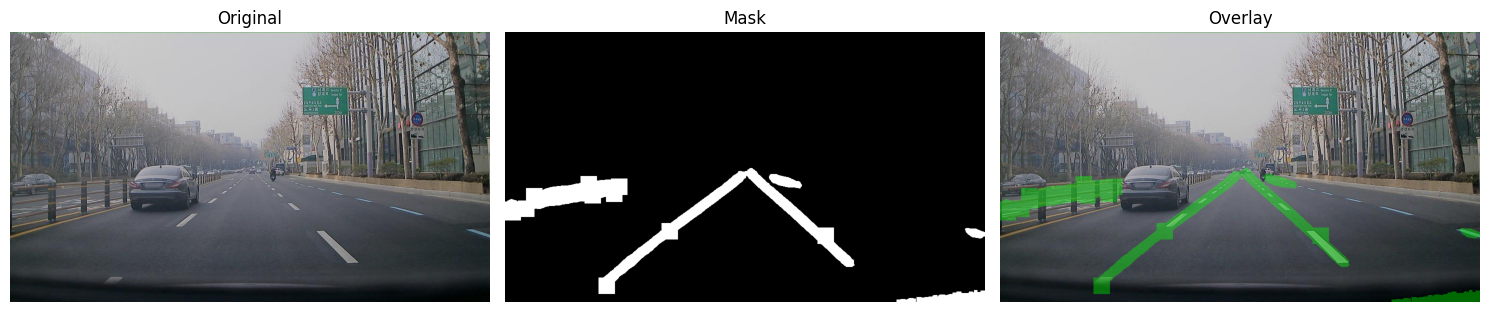

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ———— 파일 경로 설정 ————
base     = "15493794"
# Remove the zero-width space character after 'viz_origin/'
orig_fp  = f"/content/drive/MyDrive/viz_origin/{base}_origin.png"
dam_fp   = f"/content/drive/MyDrive/viz_origin_masked/{base}_origin.png"
mask_fp  = f"/content/drive/MyDrive/test_final_masks_or_0609_1117/{base}_test_or_mask.png"

# ———— 이미지 로드 ————
orig = cv2.imread(orig_fp)                      # BGR 컬러
dam  = cv2.imread(dam_fp)                       # BGR 컬러
mask = cv2.imread(mask_fp, cv2.IMREAD_GRAYSCALE)  # 그레이스케일

# Add checks to ensure images were loaded
if orig is None:
    print(f"Error loading original image: {orig_fp}")
    # You might want to exit or handle this case appropriately
    # For now, we'll just skip the rest of the cell
elif dam is None:
    print(f"Error loading damaged image: {dam_fp}")
    # Exit or handle appropriately
elif mask is None:
    print(f"Error loading mask image: {mask_fp}")
    # Exit or handle appropriately
else:
    # ———— 1) 바이너리 값 확인 ————
    uniques = np.unique(mask)
    print("Mask unique values:", uniques)
    assert set(uniques).issubset({0,255}), "마스크에 0/255 이외의 값이 섞여 있습니다!"

    # ———— 2) 커버리지 비율 확인 ————
    coverage_ratio = (mask>0).sum() / mask.size
    print(f"Mask coverage: {coverage_ratio*100:.2f}%")

    # ———— 3) 원본 위에 반투명 오버레이 ————
    # OpenCV BGR→RGB 변환
    orig_rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

    # 마스크 영역을 녹색으로 하이라이트
    highlight = orig_rgb.copy()
    highlight[mask>0] = (0,255,0)

    # 블렌딩
    alpha = 0.4
    overlay = cv2.addWeighted(orig_rgb, 1-alpha, highlight, alpha, 0)

    # ———— 4) 시각화 ————
    fig, axes = plt.subplots(1,3, figsize=(15,5))
    axes[0].imshow(orig_rgb); axes[0].set_title("Original");        axes[0].axis("off")
    axes[1].imshow(mask, cmap="gray"); axes[1].set_title("Mask");   axes[1].axis("off")
    axes[2].imshow(overlay); axes[2].set_title("Overlay");          axes[2].axis("off")
    plt.tight_layout()
    plt.show()

### 성능 비교

In [ ]:
import os, numpy as np
import torch
from PIL import Image
from piq import ssim, psnr  # pip install piq
import lpips                    # pip install lpips

# (a) LPIPS 모델 로드
lpips_fn = lpips.LPIPS(net='alex').to(device)

metrics = []
for fn in image_files:
    orig = np.array(Image.open(f"{gt_folder}/{fn}.png").convert("L"))/255.
    base = np.array(Image.open(f"{baseline_folder}/{fn}_inpainted.png").convert("L"))/255.
    ref  = np.array(Image.open(f"{refined_folder}/{fn}_refined.png").convert("L"))/255.

    orig_t = torch.from_numpy(orig)[None,None].to(device)
    base_t = torch.from_numpy(base)[None,None].to(device)
    ref_t  = torch.from_numpy(ref)[None,None].to(device)

    m_base = {
       "ssim": float(ssim(base_t, orig_t, data_range=1.0)),
       "psnr": float(psnr(base_t, orig_t, data_range=1.0)),
       "lpips": float(lpips_fn(base_t.repeat(1,3,1,1), orig_t.repeat(1,3,1,1))),
    }
    m_ref = {
       "ssim": float(ssim(ref_t, orig_t, data_range=1.0)),
       "psnr": float(psnr(ref_t, orig_t, data_range=1.0)),
       "lpips": float(lpips_fn(ref_t.repeat(1,3,1,1), orig_t.repeat(1,3,1,1))),
    }
    metrics.append((fn, m_base, m_ref))

# 결과 집계
import pandas as pd
df = pd.DataFrame([
    {
      "file": fn,
      **{"base_"+k:v for k,v in m_base.items()},
      **{"ref_" +k:v for k,v in m_ref .items()},
    }
    for fn,m_base,m_ref in metrics
])
df_means = df.mean(numeric_only=True)
print(df_means)
